# Heterogeneity analysis

This notebook loads and computes the main figures seen in JGR: Atmosphers paper "Observations and model simulations of phase heterogeneity in Arctic clouds". The data used here includes post-processed hydrometeor statistics from HoloBalloon, Cloudnet target classification data, and three separate model simulations performed with WRF.

This notebook assumes preprocessed data. See file 240902_Preprocessing.ipynb for how to preprocess into the right format.

### Imports

In [2]:
# Imports
import xarray as xr
import numpy as np, matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from datetime import datetime, timedelta
import pandas as pd
import seaborn as sns
import matplotlib as mpl

# Figure settings
mpl.rcParams['figure.dpi'] = 200
plt.rcParams.update({'font.size': 12})

# Path to data locations
CN_path = '/nird/projects/NS9600K/sldam/data/cloudnet_data/20191112_ny-alesund_classification.nc'

HB1_path = '/nird/projects/NS9600K/sldam/data/nascent_data/HoloBalloon/HoloBalloon_t30/191112_1_t30.nc'
HB2_path = '/nird/projects/NS9600K/sldam/data/nascent_data/HoloBalloon/HoloBalloon_t30/191112_2_t30.nc'
HB3_path = '/nird/projects/NS9600K/sldam/data/nascent_data/HoloBalloon/HoloBalloon_t30/191112_3_t30.nc'

#MD3_processed_path = '/nird/projects/NS9600K/sldam/data/my_processed_data/MD3_HighRes_12Nov_IWF_CT_winddir.nc' # 1-min, IWF, wind, CT, full 12 Nov
#MA3_processed_path = '/nird/projects/NS9600K/sldam/data/my_processed_data/MA3_HighRes_12Nov_IWF_CT_winddir.nc' # 1-min, IWF, wind, CT, full 12 Nov
#MAS3_processed_path = '/nird/projects/NS9600K/sldam/data/my_processed_data/MAS3_HighRes_12Nov_IWF_CT_winddir.nc' # 1-min, IWF, wind, CT, full 12 Nov

MD3_processed_path = '/nird/projects/NS9600K/sldam/data/processed_data_no_threshold/MD3_HighRes_12Nov_IWF_CT_winddir.nc' # No CLDFRA threshold
MA3_processed_path = '/nird/projects/NS9600K/sldam/data/processed_data_no_threshold/MA3_HighRes_12Nov_IWF_CT_winddir.nc' # No CLDFRA threshold
MAS3_processed_path = '/nird/projects/NS9600K/sldam/data/processed_data_no_threshold/MAS3_HighRes_12Nov_IWF_CT_winddir.nc' # No CLDFRA threshold


# Aug 30, 24: New colors tested against color blindness  simulator
model_colors = ['#6E5CBB', '#8DC3DC', '#A64A36', '#CC793B', '#F1B872']
colors = {'Default': '#A64A36', 'Adapted': '#CC793B', 'Adapted+SIP': '#F1B872', 'CloudNet': '#8DC3DC', 'HoloBalloon': '#6E5CBB'}
phase_colors = ['#3188B9', '#5BB558', '#ACADAC']
phase_labels = ['liquid', 'mixed', 'ice']

### Importing and preprocessing data

This section serves the purpose of importing the data, and homogenizing the formats. The main function is to bring all the data formats to the same structure, with a 2D (1D HoloBalloon) field of classified cloud information, where 0 is liquid, 1 is mixed-phase and 2 is ice.

In [3]:
# Helper functions for importing and processing the data to prepare and simplify analysis

def get_CN(datapath):
    '''
    Import the Cloudnet classification product and rename the classes relevant here

    Arguments:
    datapath  (str)            - path to location where data is stored
    Returns:
    to_ret    (xarray Dataset) - time-height xarray Dataset field with classified cloud according to Cloudnet         
    '''

    CN = xr.open_dataset(datapath).isel(height=slice(None, 350)).target_classification.transpose()
    CN = xr.where((CN != 1) & (CN != 4) & (CN != 5), x=np.nan, y=CN)

    to_ret = xr.where(CN==4, x=2, y=CN) # Ice
    to_ret = xr.where(CN==1, x=0, y=to_ret) # Liquid
    to_ret = xr.where(CN==5, x=1, y=to_ret) # Mixed
    return to_ret

def get_HB(datapath, tslice, threshold=0.1):
    '''
    Import the HoloBalloon ice water fraction data, convert time format, and classify

    Arguments:
    datapath  (str)            - path to location where data is stored
    tslice    (slice)          - slice object of the timesteps to use for analysis. This needs to be specified manually to exclude ascent/descent
    threshold (float)          - IWF thresholds used to distingish the mixed-phase zone. Default is 0.1, following Korolev et al. (2003). 
    Returns:
    to_ret    (xarray Dataset) - xarray Dataarray timeseries of classified cloud according to HoloBalloon         
    '''
    HB = xr.open_dataset(datapath).isel(time=tslice)

    times = HB.time.to_numpy()
    t = np.array([datetime.fromordinal(int(t) - 366) + timedelta(days=t%1) for t in times])
    HB['time'] = t

    IWF = HB.Ice_content / HB.Total_content
    classified = xr.where(IWF > 1 - threshold, x=2, y=IWF)
    classified = xr.where(IWF < threshold, x = 0, y=classified)
    to_ret = xr.where((IWF < 1 - threshold) & (IWF > threshold), x=1, y=classified)
    return to_ret


def get_processed_data(datapath, threshold=0.1):
    '''
    Import the WRF simulation preprocessed data and classify

    Arguments:
    datapath       (str)            - path to location where data is stored
    threshold      (float)          - IWF thresholds used to distingish the mixed-phase zone. Default is 0.1, following Korolev et al. (2003). 
    Returns:
    IWF_classified (xarray Dataset) - xarray Dataset with time/height field of classified cloud         
    '''
    x, y = 43, 50
    data = xr.open_dataset(datapath).IWF.isel(west_east=x, south_north=y)
    return classify_IWF(data, threshold=threshold)
 
def classify_IWF(IWF, threshold=0.1):
    '''Classify phase based on given IWF thresholds. Default is 0.1 and 0.9, following Korolev et al. (2003)'''
    IWF_classified = xr.where((IWF < 1-threshold) & (IWF > threshold), x=0.5, y=IWF) # mixed-phase
    IWF_classified = xr.where(IWF > 1-threshold, x=1, y=IWF_classified) # ice
    IWF_classified = xr.where(IWF < threshold, x=0, y=IWF_classified).T * 2 # liquid
    return IWF_classified

### Setup

In [4]:
limit_time = True # Option to use only data from when holoballoon was flying
threshold = 0.1   # Threshold for IWF to use when classifying liquid/mixed/ice.

subsample = 2           # Select only every other timestep to match resolution of model
subsample_variation = 0 # Skip the first timestep to select 'the other' subsampling alternative

#Model levels (found by wrf.getvar(nc.Dataset(MAS3_path), 'z').isel(bottom_top=slice(0, 85), west_east=50, south_north=50).to_numpy())
h = np.array([11.3408785,   34.04713,   56.80371,   79.61095, 102.47005,  125.38474,  148.3563 ,  171.38313,
    194.46507,  217.6024 ,  240.79466,  264.04178, 287.3438 ,  310.70056,  334.11267,  357.57974,
    381.10104,  404.67712,  428.30814,  451.99432, 475.73615,  499.5331 ,  523.38495,  547.292  ,
    571.2547 ,  595.27405,  619.34924,  643.4812 , 667.672  ,  691.9206 ,  716.2291 ,  740.60077,
    765.0361 ,  789.5347 ,  814.0979 ,  838.726  , 863.419  ,  888.1784 ,  913.0036 ,  937.8924 ,
    962.8429 ,  987.85596, 1012.93317, 1038.0742 , 1063.2799 , 1088.5518 , 1113.89   , 1139.2958 ,
    1164.7697 , 1190.3134 , 1220.2161 , 1254.5106 , 1288.9487 , 1323.539  , 1358.2928 , 1393.2336 ,
    1428.377  , 1463.725  , 1499.282  , 1535.0516 , 1571.0369 , 1607.2264 , 1643.6042 , 1680.1637 ,
    1716.9023 , 1753.8174 , 1790.9053 , 1828.1632 , 1865.5887 , 1903.1819 , 1940.9419 , 1978.8679 ,
    2016.9591 , 2055.214  , 2093.6353 , 2137.0706 , 2185.5688 , 2234.331  , 2283.3591 , 2332.6555 ,
    2382.2231 , 2432.0654 , 2482.1836 , 2532.5793 , 2583.2563])

#Accessing HoloBalloon data
HB_tslices = [slice(20, 136), slice(32, 191), slice(30, 274)]
HB = xr.concat([get_HB(path, tslice, threshold=threshold) for path, tslice in zip((HB1_path, HB2_path, HB3_path), HB_tslices)], dim='time')
HB = HB.isel(time=slice(subsample_variation, None, subsample))
HB_heights = xr.concat([xr.open_dataset(path).isel(time=tslice).instData_height for path, tslice in zip((HB1_path, HB2_path, HB3_path), HB_tslices)], dim='time')


# Option to use only data from when holoballoon was flying
tslice_M = slice(None, None)
tslice_CN = slice(subsample_variation, None, subsample)
if limit_time:
    tslice_M = slice(600, 1021)
    #tslice_CN = slice(1185 + subsample_variation, 2018)
    tslice_CN = slice('2019-11-12T09:59:45', '2019-11-12T17:00:20')

CN = get_CN(CN_path).sel(time=tslice_CN).isel(time=slice(subsample_variation, None, subsample))

MD3 = get_processed_data(MD3_processed_path, threshold=threshold).rename({'bottom_top': 'height', 'Time': 'time'}).isel(time=tslice_M)
MA3 = get_processed_data(MA3_processed_path, threshold=threshold).rename({'bottom_top': 'height', 'Time': 'time'}).isel(time=tslice_M)
MAS3 = get_processed_data(MAS3_processed_path, threshold=threshold).rename({'bottom_top': 'height', 'Time': 'time'}).isel(time=tslice_M)


### Helper functions for calculations

In [5]:
def add_arrays(a, b):
    # Function to add together the counted pocket lengths for each of the layers
    if type(a) == int:
        return b
    result_inds = np.unique(list(a[0]) + list(b[0]))
    result_counts = []

    current_ai = 0
    current_bi = 0

    for i in result_inds:
        if i in a[0] and i in b[0]:
            result_counts.append(a[1][current_ai] + b[1][current_bi])
            current_ai += 1
            current_bi += 1
        
        elif i in a[0]:
            result_counts.append(a[1][current_ai])
            current_ai += 1

        elif i in b[0]:
            result_counts.append(b[1][current_bi])
            current_bi += 1

        else:
            print('Fatal error')

    return np.array([result_inds, result_counts])

def select_layer(input, n=0, reference_level=None):
    # select nth layer counting from reference_level or top
    if reference_level is None: # Assume cloud top as reference level
        hc = xr.where(input >= 0, x=input.height, y=0)
        reference_level = hc.argmax(dim='height')
    
    return input.isel(height=reference_level - n)
    
def select_layers(input, n=2, reference_level=None):
    # Select n layers counting from cloud top or reference layer down
    total = select_layer(input, n=0, reference_level=reference_level)
    for i in range(1, n):
        total = xr.concat([total, select_layer(input, i, reference_level)], dim='y')
    return total.rename({'y': 'height'})

def compute_segment_lengths(data, target_number):
    # Find consecutive segments containing the target number (0 liquid, 1 mixed, 2 ice)
    consecutive_segments = np.split(data, np.where(np.diff(np.concatenate(([0], data == target_number, [0]))) != 0)[0])

    # Remove empty segments and count lengths
    segment_lengths = [len(seg) for seg in consecutive_segments if len(seg) > 0 and seg[0] == target_number]

    if segment_lengths == []:
        lengths, counts = [1], [0]
    
    else:
        # Count occurrences of each segment length
        length_counts = {length: segment_lengths.count(length) for length in set(segment_lengths)}

        lengths, counts = zip(*sorted(length_counts.items()))
    return np.array([lengths, counts])

def find_min_max(array1, array2, operator=np.max):
    '''Keep the max or min counts for each index in two sets of indices and counts'''
    
    try:
        combined_array = np.column_stack((array1, array2)) # Stack arrays together
    except ValueError:
        array1 = np.array([[], []])
        combined_array = np.column_stack((array1, array2))

    unique_indices = np.unique(combined_array[0]) # Keep only unique indices

    result = np.zeros_like(unique_indices, dtype=int) # Initialize resulting array to fill


    for idx in unique_indices: # loop through unique_indiced and keep max/min counts
        index_mask = combined_array[0] == idx
        result[np.where(unique_indices == idx)] = operator(combined_array[1, index_mask])

    return np.array([unique_indices, result], int)

def mean_median_length(segment_lengths, stat='median'):
        '''Find the mean or median segment length of input [[lengths, counts]]'''
        if stat == 'median':
            return np.median(np.repeat(segment_lengths[0], segment_lengths[1]))
        elif stat =='mean':
            return np.mean(np.repeat(segment_lengths[0], segment_lengths[1]))
        else:
            raise ValueError('stat must be either median or mean')
        
def median_length(segment_lengths):
    if len(segment_lengths) == 3: # All phases
        tot = add_arrays(add_arrays(segment_lengths[0], segment_lengths[1]), segment_lengths[2])
        mean = np.median(np.repeat(tot[0], tot[1]))
    else: # Single phase entered
        mean = np.median(np.repeat(segment_lengths[0], segment_lengths[1]))

    return mean

def mean_length(segment_lengths):
    if len(segment_lengths) == 3: # All phases
        tot = add_arrays(add_arrays(segment_lengths[0], segment_lengths[1]), segment_lengths[2])
        mean = np.mean(np.repeat(tot[0], tot[1]))
    else: # Single phase entered
        mean = np.mean(np.repeat(segment_lengths[0], segment_lengths[1]))

    return mean

def repmat(arr):
    return [np.repeat(a[0], a[1]) for a in arr]

def continuous_indices(segment_lengths):
    continuous_segment_lengths = []
    for phase in segment_lengths:
        indices, counts = phase
        
        new_indices = np.arange(1, 3000)
        index_to_count = dict(zip(indices, counts))
        new_counts = np.array([index_to_count.get(i, 0) for i in new_indices])
        continuous_segment_lengths.append([new_indices, new_counts])
    return continuous_segment_lengths



def get_segment_lengths(data, n_layers, reference_level=None, continuous=True):
    segment_lengths = [[], [], []]

    for i in range(3):
        TOT = 0
        if n_layers != 1:
            for n in range(n_layers):
                seg_lens = compute_segment_lengths(select_layer(data, n=n, reference_level=reference_level), target_number=i)
                TOT = add_arrays(TOT, seg_lens)
        else:
            TOT = compute_segment_lengths(data, target_number=i)
        segment_lengths[i] = TOT
    if continuous:
        return continuous_indices(segment_lengths)
    else:
        return segment_lengths
    
def SHS(segment_lengths):
    '''Spatial Heterogeneity Score based on dAllesandro etal (2021)'''
    try: # All phases
        n_samples = sum([sum(x[0] * x[1]) for x in segment_lengths])
        n_segments = sum([sum(x[1]) for x in segment_lengths])
    except TypeError: # Single phase entered
        n_samples = sum(segment_lengths[0] * segment_lengths[1])
        n_segments = sum(segment_lengths[1])

    return (n_samples - n_segments) / (n_samples - 1)


def plot_heterogeneity(data, ax, title, km_conversion=1, percent=True, stat='median'):
    ''' Plot the heterogeneity plot from given pocket length counts per phase.
        data should be for format [liquid, mixed, ice] where each of liquid/mixed/ice are 2d-arrays with
        pocket lengths and counts.'''

    TOTAL_N_POCKETS = np.sum([np.sum(phase[1]) for phase in data])
    textstring = 'Pocket occurrence: \n'
    pc = 1
    if percent:
        pc = 100
    
    for i, phase in enumerate(data):
        ax.plot(phase[0] * km_conversion, phase[1] / TOTAL_N_POCKETS * pc, color=phase_colors[i], label=phase_labels[i], linewidth=2)
        ax.axvline(mean_median_length(phase, stat=stat) * km_conversion, linestyle='dashed', color=phase_colors[i], alpha=0.5)

        textstring += f'{phase_labels[i]}={round(sum(phase[1]) / TOTAL_N_POCKETS * 100, 1)}%\n'
    ax.axvline(-100, linestyle='dashed', color='black', label=stat)

    ax.text(0.97, 0.979, textstring, transform=ax.transAxes,
        verticalalignment='top', horizontalalignment='right',
        bbox=dict(facecolor='white', edgecolor='none'))
    
    ax.set_title(title)

# Analysis

### Part 1: Phase occurrence

/tmp/ipykernel_2711883/3370832365.py:43: UserWarning: rename 'y' to 'height' does not create an index anymore. Try using swap_dims instead or use set_index after rename to create an indexed coordinate.
  return total.rename({'y': 'height'})


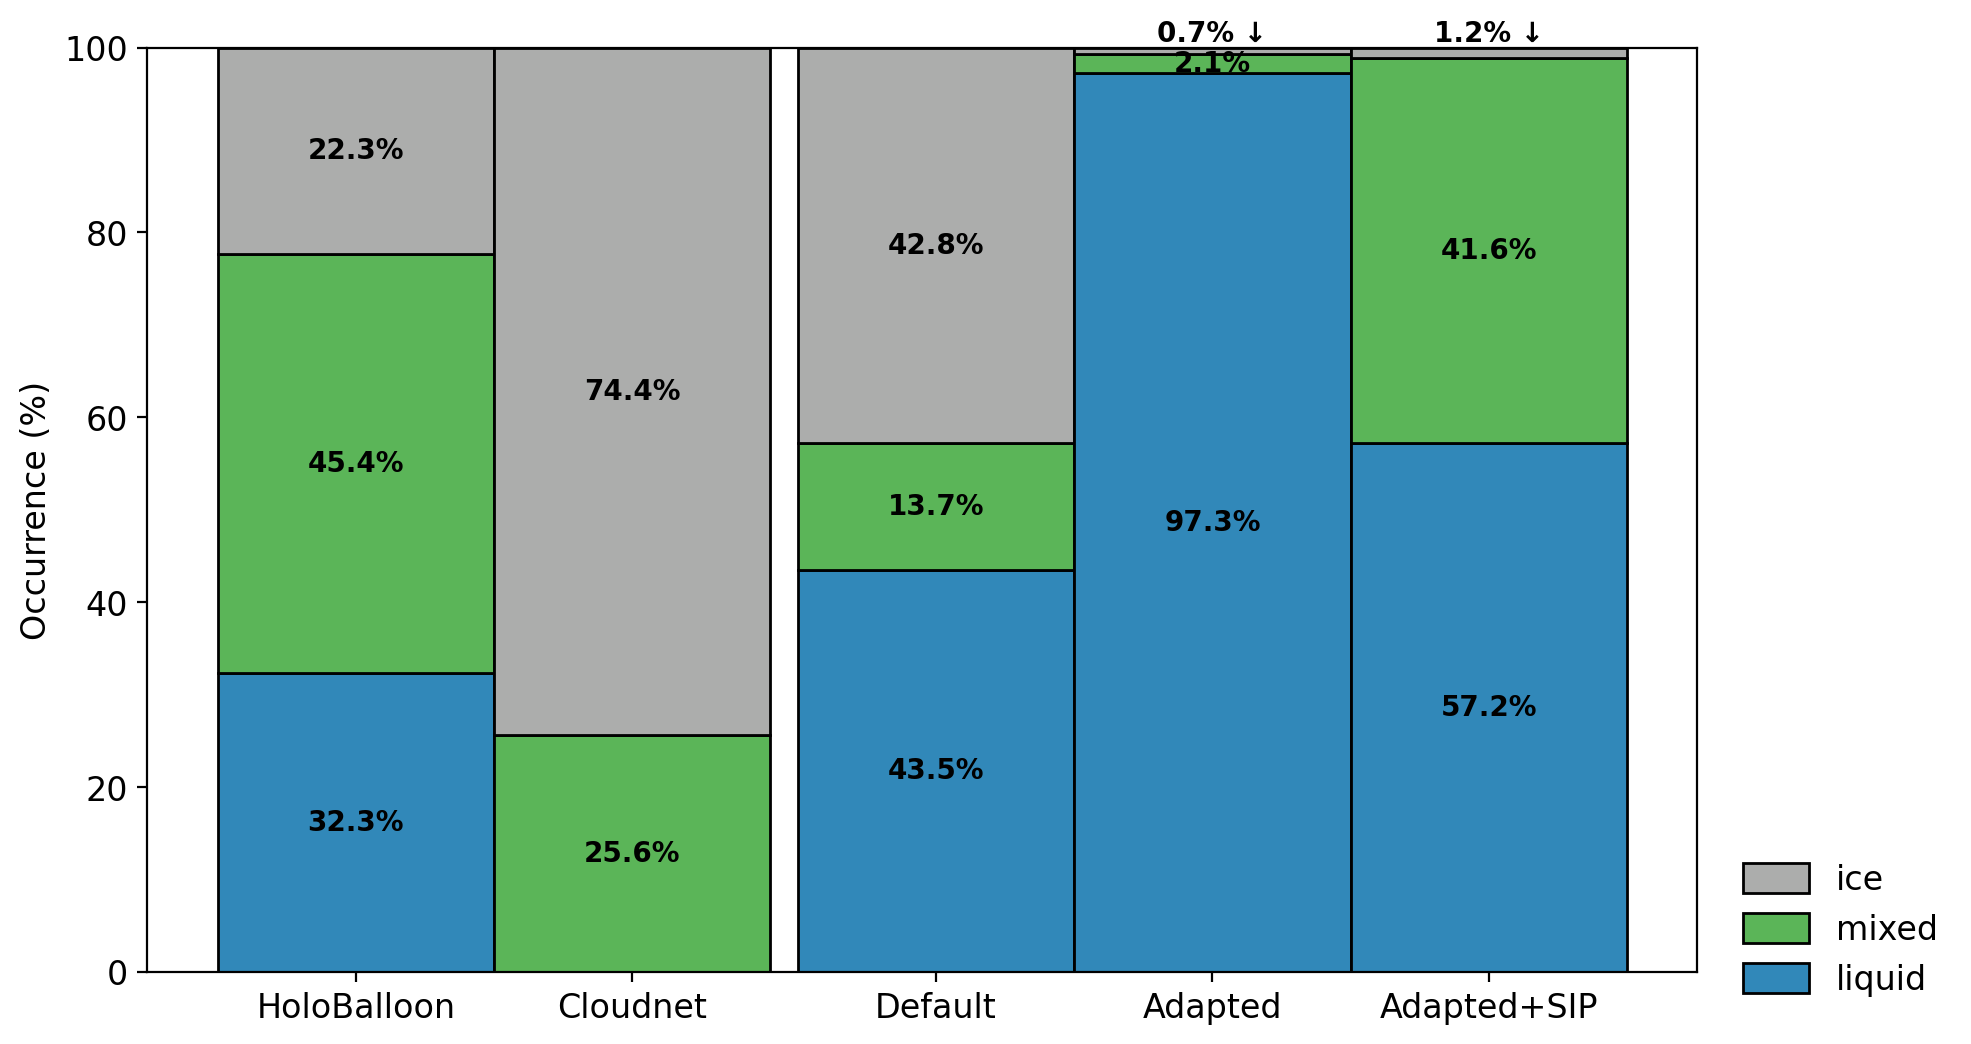

In [6]:
# Cloud interior

fig, ax = plt.subplots(1, 1, figsize=(10, 6))

x = [1, 2, 3.1, 4.1, 5.1]

model_labels = ['HoloBalloon', 'Cloudnet', 'Default', 'Adapted', 'Adapted+SIP']
phase_patterns = ['o', 'x', '*']


phase_colors = ['#3188B9', '#5BB558', '#ACADAC']
for i, data in enumerate([HB, 
                          select_layers(CN, n=30, reference_level=137), 
                          select_layers(MD3, n=9, reference_level=32), 
                          select_layers(MA3, n=9, reference_level=32), 
                          select_layers(MAS3, n=9, reference_level=32)]):
    counts = np.array([xr.where(data==phase, x=True, y=np.nan).count() for phase in range(3)])
    total = np.sum(counts)
    norm = counts / total * 100 # Occurrence in percent
    
    for phase in range(3):
        plt.bar(x=x[i], height=norm[phase], bottom=norm[:phase].sum(), alpha=1, edgecolor='k', width=1, color=phase_colors[phase])# hatch=phase_patterns[phase], color='w')#model_colors[i])

for bar in ax.patches:
  if bar.get_height() > 2:
    ax.text(bar.get_x() + bar.get_width() / 2,
            bar.get_height() / 2 + bar.get_y() - 0.8,
            f'{round(bar.get_height(), 1)}%', ha = 'center',
            color = 'k', weight = 'bold', size = 10)#, backgroundcolor='w', bbox=dict(facecolor='w', edgecolor='grey'))
  elif bar.get_height() > 1.5:
    ax.text(bar.get_x() + bar.get_width() / 2,
            bar.get_height() / 2 + bar.get_y() - 3 - bar.get_height() *0.6,
            f'{round(bar.get_height(), 1)}% \u2191', ha = 'center',
            color = 'k', weight = 'bold', size = 10)#, backgroundcolor='w', bbox=dict(facecolor='w', edgecolor='grey'))
  elif bar.get_height() > 0.1:
    ax.text(bar.get_x() + bar.get_width() / 2,
            bar.get_height() / 2 + bar.get_y() + 0.7 + bar.get_height()*0.5,
            f'{round(bar.get_height(), 1)}% \u2193', ha = 'center',
            color = 'k', weight = 'bold', size = 10)#, backgroundcolor='w', bbox=dict(facecolor='w', edgecolor='grey'))

plt.legend(labels=phase_labels, bbox_to_anchor=(1.01, 0.15), frameon=False, handleheight=1, fontsize=12, reverse=True)
#plt.tick_params(bottom=False)
plt.xticks(ticks=x, labels=model_labels, fontsize=12)
plt.ylim(0, 100)
plt.ylabel('Occurrence (%)', fontsize=12)
plt.show()


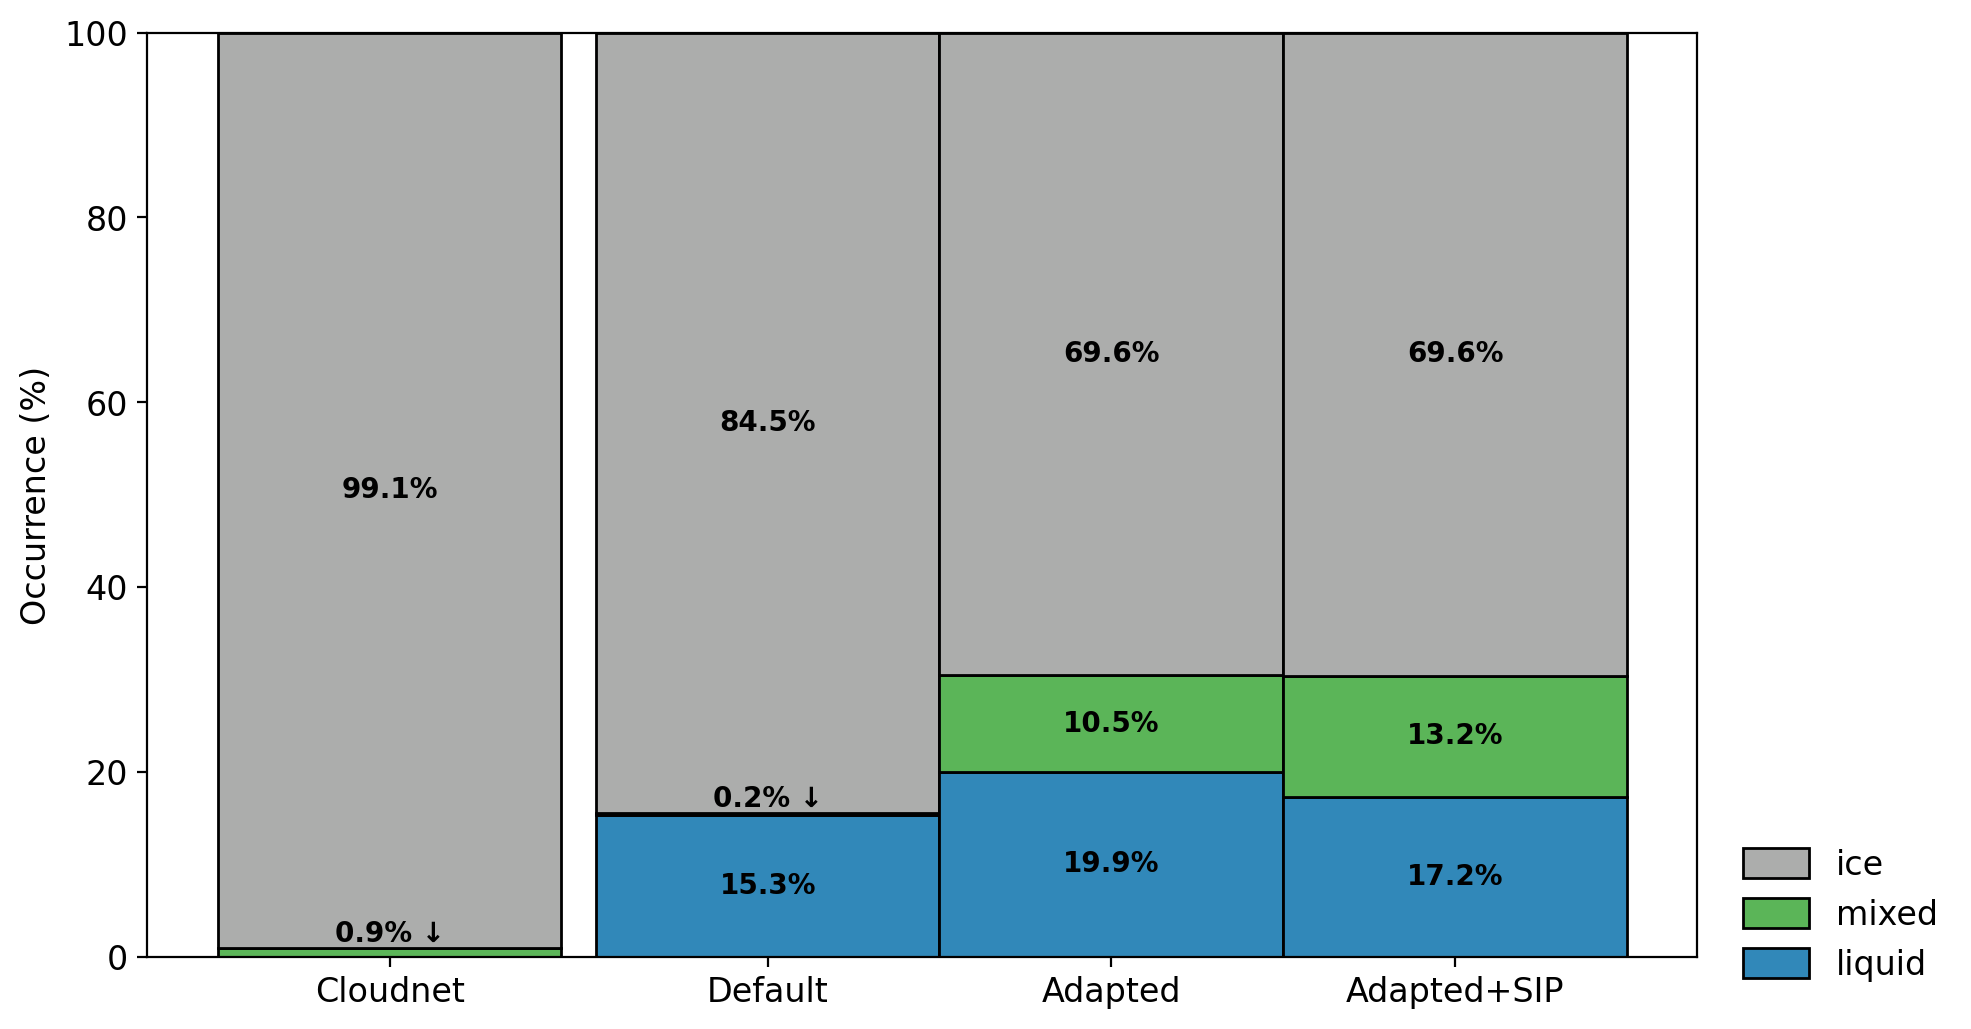

In [7]:
# Cloud top

fig, ax = plt.subplots(1, 1, figsize=(10, 6))

x = [2, 3.1, 4.1, 5.1]

model_labels = ['Cloudnet', 'Default', 'Adapted', 'Adapted+SIP']
phase_patterns = ['o', 'x', '*']


phase_colors = ['#3188B9', '#5BB558', '#ACADAC']
for i, data in enumerate([select_layers(CN, n=30), 
                          select_layers(MD3, n=9), 
                          select_layers(MA3, n=9), 
                          select_layers(MAS3, n=9)]):
    counts = np.array([xr.where(data==phase, x=True, y=np.nan).count() for phase in range(3)])
    total = np.sum(counts)
    norm = counts / total * 100 # Occurrence in percent
    
    for phase in range(3):
        plt.bar(x=x[i], height=norm[phase], bottom=norm[:phase].sum(), alpha=1, edgecolor='k', width=1, color=phase_colors[phase])# hatch=phase_patterns[phase], color='w')#model_colors[i])

for bar in ax.patches:
  if bar.get_height() > 1:
    ax.text(bar.get_x() + bar.get_width() / 2,
            bar.get_height() / 2 + bar.get_y() - 0.8,
            f'{round(bar.get_height(),1)}%', ha = 'center',# backgroundcolor='white',
            color = 'k', weight = 'bold', size = 10)#, backgroundcolor='w', bbox=dict(facecolor='w', edgecolor='grey'))
  elif bar.get_height() > 0.1:
    ax.text(bar.get_x() + bar.get_width() / 2,
            bar.get_height() / 2 + bar.get_y() + 0.7 + bar.get_height()*0.5,
            f'{round(bar.get_height(), 1)}% \u2193', ha = 'center',
            color = 'k', weight = 'bold', size = 10)#, backgroundcolor='w', bbox=dict(facecolor='w', edgecolor='grey'))

plt.legend(labels=phase_labels, bbox_to_anchor=(1.01, 0.15), frameon=False, handleheight=1, fontsize=12, reverse=True)
#plt.tick_params(bottom=False)
plt.xticks(ticks=x, labels=model_labels, fontsize=12)
plt.ylim(0, 100)
plt.ylabel('Occurrence (%)', fontsize=12)
plt.show()

### Part 2: CDFs

/nird/projects/NS9600K/sldam/miniconda3/envs/P1/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


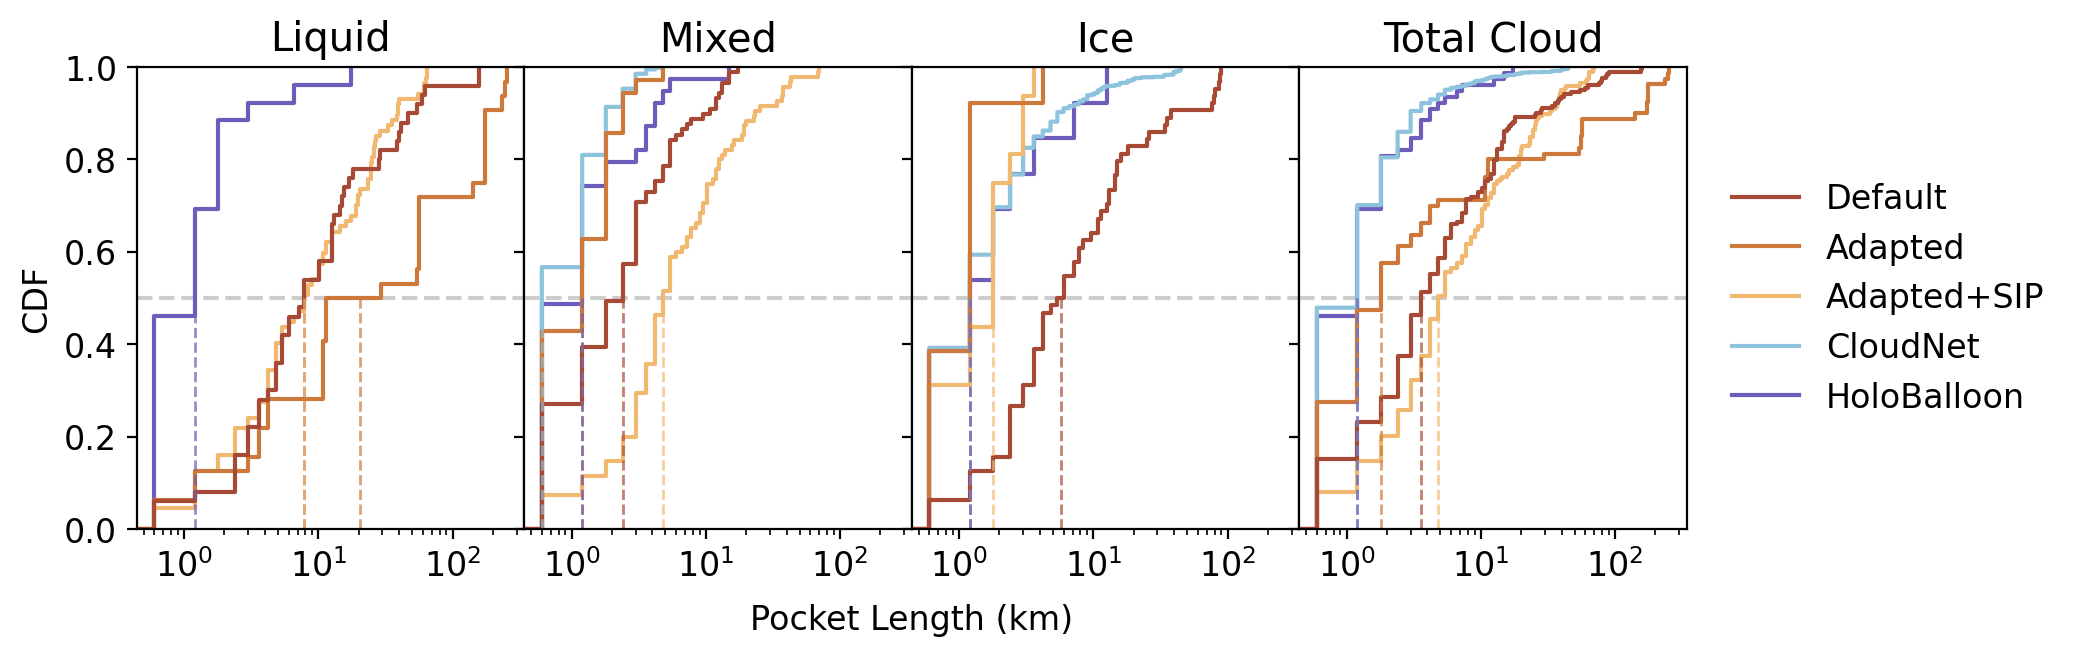

In [8]:
# Cloud interior

fig, ax = plt.subplots(1, 4, figsize=(10, 3), sharey=True, sharex=True)


D = [L * 0.6 for L in repmat(continuous_indices(get_segment_lengths(MD3, n_layers=9, reference_level=32)))]
A = [L * 0.6 for L in repmat(continuous_indices(get_segment_lengths(MA3, n_layers=9, reference_level=32)))]
AS = [L * 0.6 for L in repmat(continuous_indices(get_segment_lengths(MAS3, n_layers=9, reference_level=32)))]

C = [L * 0.3 * subsample for L in repmat(continuous_indices(get_segment_lengths(CN, n_layers=30, reference_level=137)))]
H = [L * 0.3 * subsample for L in repmat(get_segment_lengths(HB, n_layers=1))]

liquid_df = pd.DataFrame([D[0], A[0], AS[0], C[0], H[0]], index=['Default', 'Adapted', 'Adapted+SIP', 'CloudNet', 'HoloBalloon']).T.assign(phase='liquid')
mixed_df = pd.DataFrame([D[1], A[1], AS[1], C[1], H[1]], index=['Default', 'Adapted', 'Adapted+SIP', 'CloudNet', 'HoloBalloon']).T.assign(phase='mixed')
ice_df = pd.DataFrame([D[2], A[2], AS[2], C[2], H[2]], index=['Default', 'Adapted', 'Adapted+SIP', 'CloudNet', 'HoloBalloon']).T.assign(phase='ice')
total_df = pd.DataFrame([np.concatenate([e[0], e[1], e[2]]) for e in [D, A, AS, C, H]], index=['Default', 'Adapted', 'Adapted+SIP', 'CloudNet', 'HoloBalloon']).T.assign(phase='total')

phase_mdf = pd.melt(pd.concat([liquid_df, mixed_df, ice_df]), id_vars=['phase'])


#Power law
#x = np.linspace(0.6, 150, 500)
#y = x ** (-5/3)
#for axis in ax:
#    axis.plot(x, np.cumsum(y)/np.cumsum(y)[-1], linestyle='dashed', color='k', alpha=0.5)

for x in ax:
    x.axhline(0.5, linestyle='dashed', color='k', alpha=0.2)

stat = 'proportion'


sns.ecdfplot(liquid_df, ax=ax[0], palette=colors, legend=False, stat=stat)
for key in colors.keys():
    ax[0].axvline(liquid_df[key].median(), ymax=0.5, color=colors[key], linestyle='dashed', linewidth=1, alpha=0.7)


sns.ecdfplot(mixed_df, ax=ax[1], palette=colors, legend=False, stat=stat)
for key in colors.keys():
    ax[1].axvline(mixed_df[key].median(), ymax=0.5, color=colors[key], linestyle='dashed', linewidth=1, alpha=0.7)

sns.ecdfplot(ice_df, ax=ax[2], palette=colors, legend=False, stat=stat)
for key in colors.keys():
    ax[2].axvline(ice_df[key].median(), ymax=0.5, color=colors[key], linestyle='dashed', linewidth=1, alpha=0.7)

sns.ecdfplot(total_df, ax=ax[3], palette=colors, stat=stat)
for key in colors.keys():
    ax[3].axvline(total_df[key].median(), ymax=0.5, color=colors[key], linestyle='dashed', linewidth=1, alpha=0.7)

sns.move_legend(ax[3], 'center right', bbox_to_anchor=(2, 0.5), frameon=False)
plt.xscale('log')
#plt.ylim(0, 1.03)
ax[0].set_title('Liquid')
ax[1].set_title('Mixed')
ax[2].set_title('Ice')
ax[3].set_title('Total Cloud')
ax[0].set_ylabel('CDF')
#[x.set_xlabel('pocket length (km)') for x in ax]
ax[1].set_xlabel('Pocket Length (km)')
ax[1].xaxis.set_label_coords(1, -0.16)
plt.subplots_adjust(wspace=0)



plt.show()

/nird/projects/NS9600K/sldam/miniconda3/envs/P1/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


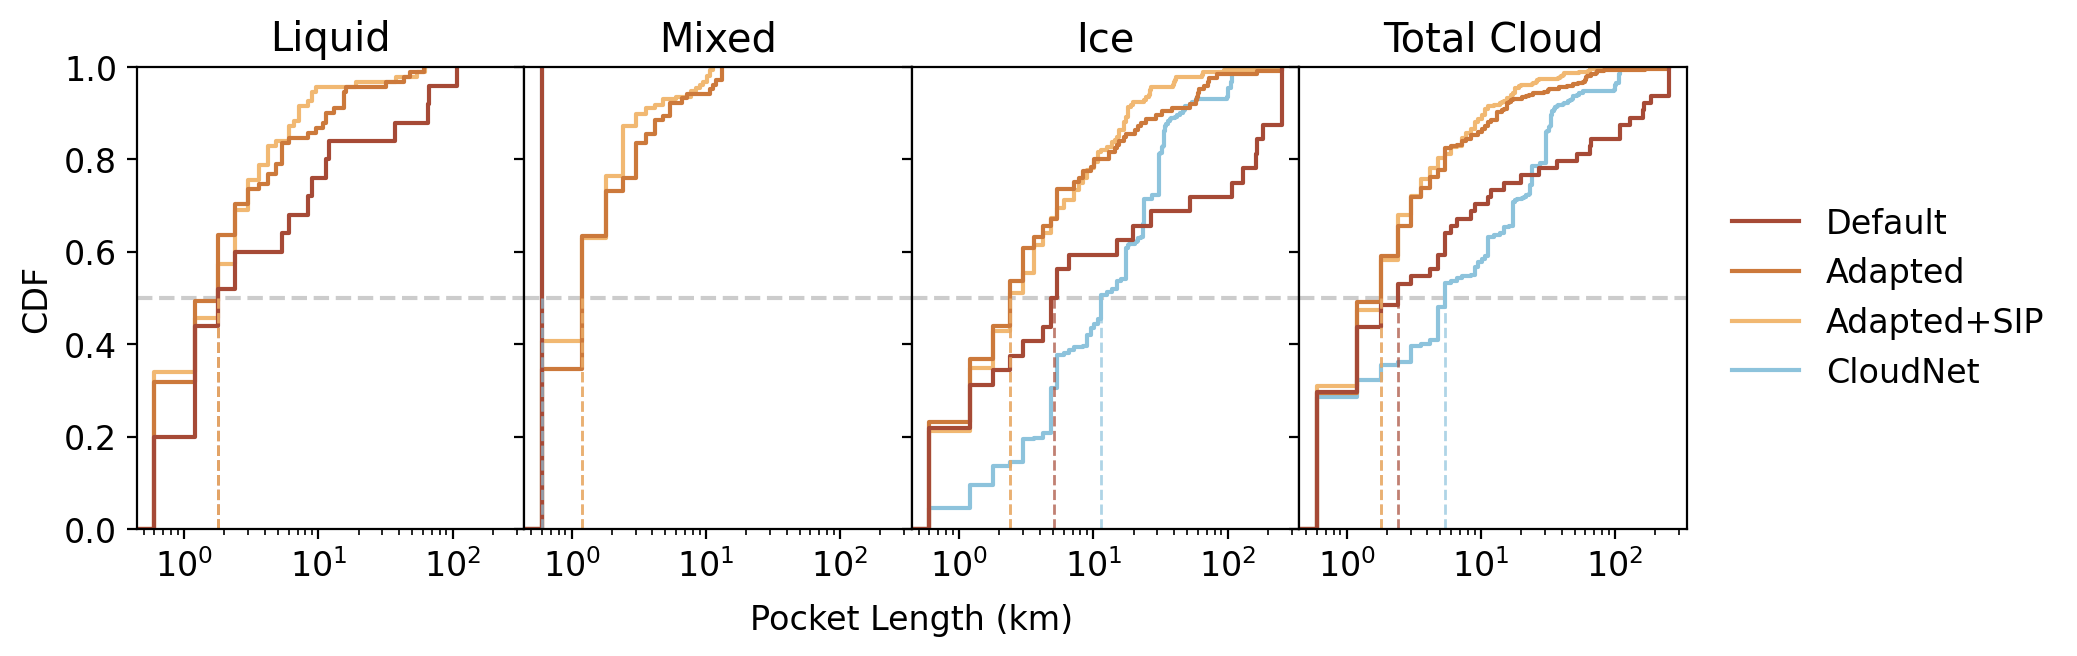

In [9]:
# Cloud top

fig, ax = plt.subplots(1, 4, figsize=(10, 3), sharey=True, sharex=True)

D = [L * 0.6 for L in repmat(continuous_indices(get_segment_lengths(MD3, n_layers=9)))]
A = [L * 0.6 for L in repmat(continuous_indices(get_segment_lengths(MA3, n_layers=9)))]
AS = [L * 0.6 for L in repmat(continuous_indices(get_segment_lengths(MAS3, n_layers=9)))]

C = [L * 0.3 * subsample for L in repmat(continuous_indices(get_segment_lengths(CN.isel(time=slice(None, None, None)), n_layers=30)))]

liquid_df = pd.DataFrame([D[0], A[0], AS[0], C[0]], index=['Default', 'Adapted', 'Adapted+SIP', 'CloudNet']).T.assign(phase='liquid')
mixed_df = pd.DataFrame([D[1], A[1], AS[1], C[1]], index=['Default', 'Adapted', 'Adapted+SIP', 'CloudNet']).T.assign(phase='mixed')
ice_df = pd.DataFrame([D[2], A[2], AS[2], C[2]], index=['Default', 'Adapted', 'Adapted+SIP', 'CloudNet']).T.assign(phase='ice')
total_df = pd.DataFrame([np.concatenate([e[0], e[1], e[2]]) for e in [D, A, AS, C]], index=['Default', 'Adapted', 'Adapted+SIP', 'CloudNet']).T.assign(phase='total')

phase_mdf = pd.melt(pd.concat([liquid_df, mixed_df, ice_df]), id_vars=['phase'])

stat='proportion'
weights = [0.5, 1, 1, 1]
for x in ax:
    x.axhline(0.5, linestyle='dashed', color='k', alpha=0.2)

stat = 'proportion'


sns.ecdfplot(liquid_df, ax=ax[0], palette=colors, legend=False, stat=stat)
for key in list(colors.keys())[:-1]:
    ax[0].axvline(liquid_df[key].median(), ymax=0.5, color=colors[key], linestyle='dashed', linewidth=1, alpha=0.7)


sns.ecdfplot(mixed_df, ax=ax[1], palette=colors, legend=False, stat=stat)
for key in list(colors.keys())[:-1]:
    ax[1].axvline(mixed_df[key].median(), ymax=0.5, color=colors[key], linestyle='dashed', linewidth=1, alpha=0.7)

sns.ecdfplot(ice_df, ax=ax[2], palette=colors, legend=False, stat=stat)
for key in list(colors.keys())[:-1]:
    ax[2].axvline(ice_df[key].median(), ymax=0.5, color=colors[key], linestyle='dashed', linewidth=1, alpha=0.7)

sns.ecdfplot(total_df, ax=ax[3], palette=colors, stat=stat)
for key in list(colors.keys())[:-1]:
    ax[3].axvline(total_df[key].median(), ymax=0.5, color=colors[key], linestyle='dashed', linewidth=1, alpha=0.7)

sns.move_legend(ax[3], 'center right', bbox_to_anchor=(2, 0.5), frameon=False)
plt.xscale('log')
#plt.ylim(0, 1.03)
ax[0].set_title('Liquid')
ax[1].set_title('Mixed')
ax[2].set_title('Ice')
ax[3].set_title('Total Cloud')
ax[0].set_ylabel('CDF')
#[x.set_xlabel('pocket length (km)') for x in ax]
ax[1].set_xlabel('Pocket Length (km)')
ax[1].xaxis.set_label_coords(1, -0.16)



plt.subplots_adjust(wspace=0)
plt.show()

### Part 3: Cloud Heterogeneity

/nird/projects/NS9600K/sldam/miniconda3/envs/P1/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/nird/projects/NS9600K/sldam/miniconda3/envs/P1/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/nird/projects/NS9600K/sldam/miniconda3/envs/P1/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  fig.canvas.print_figure(bytes_io, **kw)


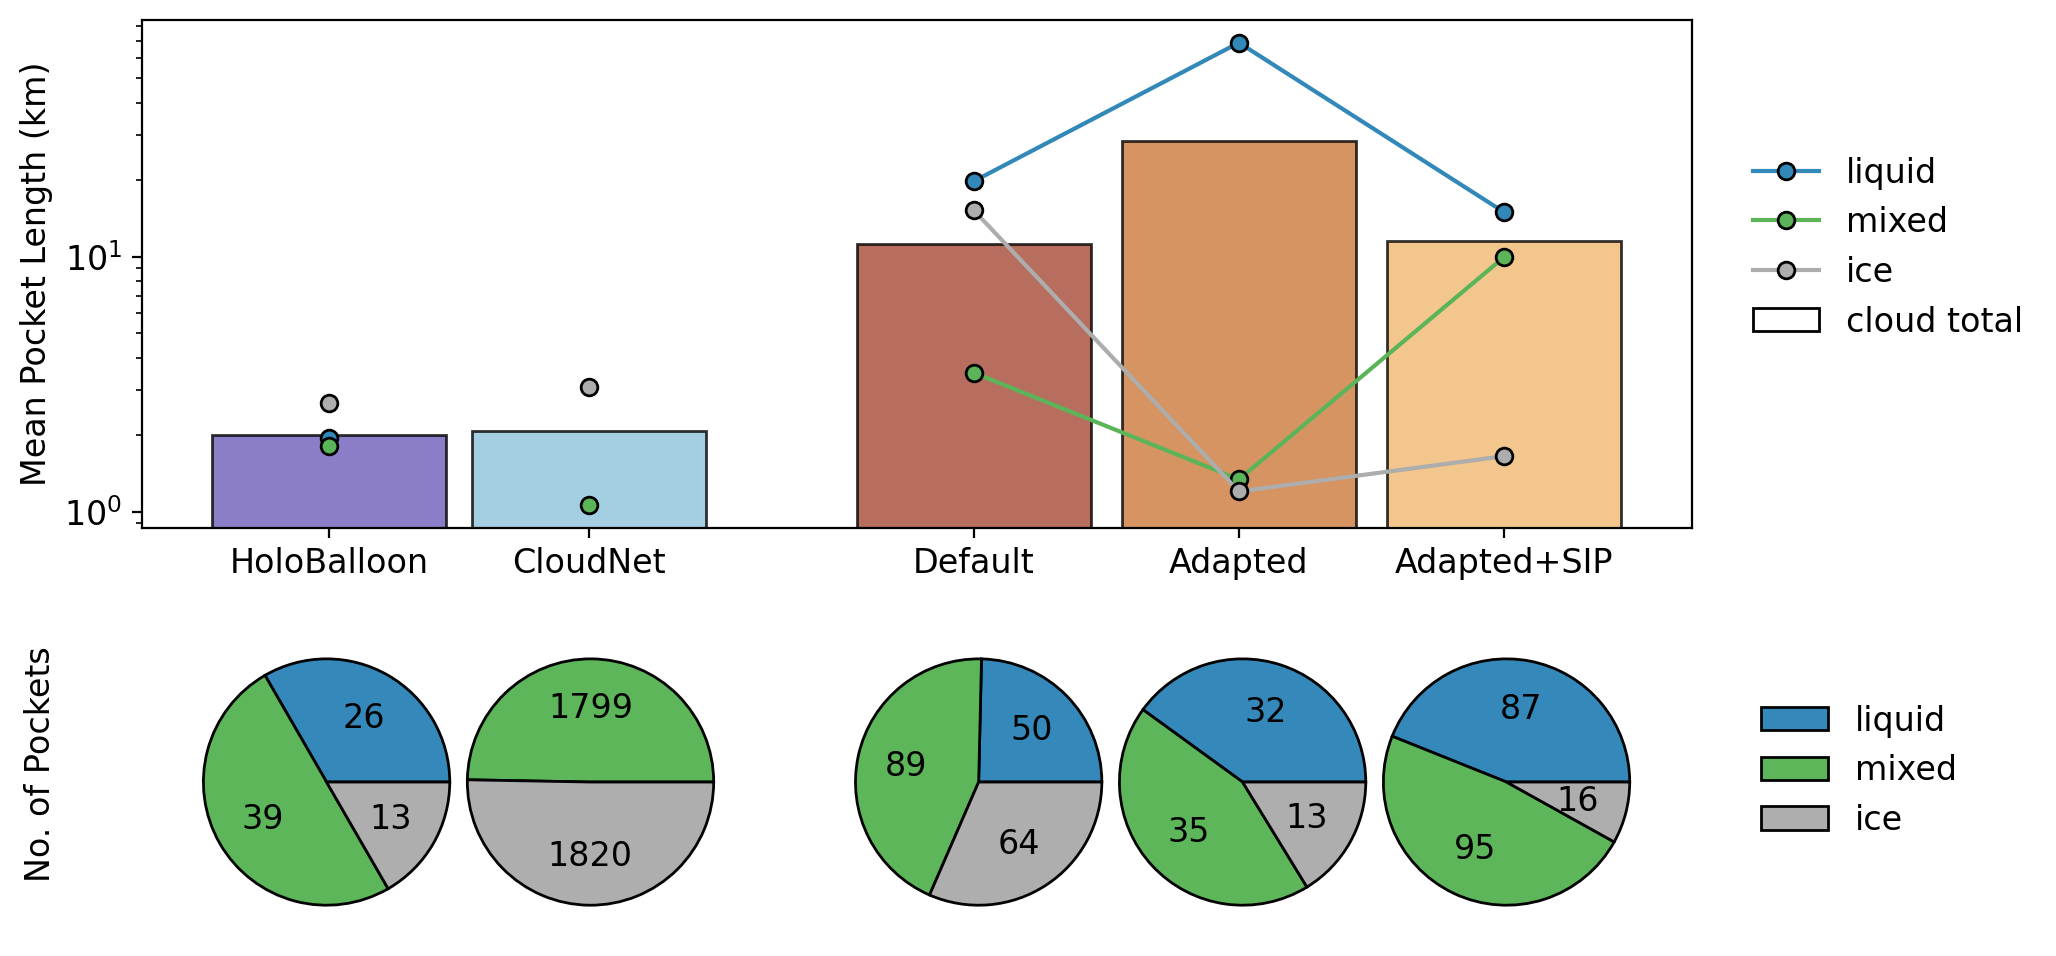

In [10]:
# Cloud interior

interior_data = [get_segment_lengths(HB, n_layers=1), 
       get_segment_lengths(CN, n_layers=30, reference_level=137), 
       get_segment_lengths(MD3, n_layers=9, reference_level=32), 
       get_segment_lengths(MA3, n_layers=9, reference_level=32), 
       get_segment_lengths(MAS3, n_layers=9, reference_level=32)]

fig = plt.figure(figsize=(10, 6), tight_layout=True)
gs = gridspec.GridSpec(100, 100)

ax0 = fig.add_subplot(gs[0:55, :])

x_positions = [1, 2, 3.48, 4.5, 5.52]


ax0.bar(x = x_positions, 
       height=[mean_length(d) * 0.6 for d in interior_data], 
       width=0.9, 
       color=model_colors, 
       edgecolor=['black']*3, linewidth=1, alpha=0.8, tick_label=['HoloBalloon', 'CloudNet', 'Default', 'Adapted', 'Adapted+SIP'])

ax0.bar(x=[2.17], height=0, alpha=1, label='cloud total', color='white', linewidth=1, edgecolor=['black']*2)


offset = False

for phase in range(3):
    ax0.plot(x_positions[2:], [mean_length(d[phase]) * 0.6 for d in interior_data[2:]], 
            color=phase_colors[phase], marker='o', label=phase_labels[phase], markeredgecolor='k')
    
    if offset:
        ax0.scatter(1 + (phase - 1) / 50, mean_length(interior_data[0][phase]) * 0.6, color=phase_colors[phase], marker='o', edgecolors='k')
        ax0.scatter(2 + (phase - 1) / 50, mean_length(interior_data[1][phase]) * 0.6, color=phase_colors[phase], marker='o', edgecolors='k')
    else:
        ax0.scatter(1, mean_length(interior_data[0][phase]) * 0.6, color=phase_colors[phase], marker='o', edgecolors='k')
        ax0.scatter(2, mean_length(interior_data[1][phase]) * 0.6, color=phase_colors[phase], marker='o', edgecolors='k')

ax0.legend(bbox_to_anchor=(1.02, 0.79), frameon=False)

dummy = fig.add_subplot(gs[80, 1])
dummy.spines['left'].set_visible(False)
dummy.spines['right'].set_visible(False)
dummy.spines['top'].set_visible(False)
dummy.spines['bottom'].set_visible(False)
dummy.set_xticks([])
dummy.set_yticks([])
dummy.set_ylabel('No. of Pockets', labelpad=36)

# Making the pie charts
def pieplot(ax, interior_data):
    counts = [sum(interior_data[phase][1]) for phase in range(3)]
    ax.pie(counts, colors=phase_colors, autopct=make_autopct(counts))

def make_autopct(values):
    # To show total counts instead of percantages
    def my_autopct(pct):
        total = sum(values)
        val = int(round(pct*total/100.0))
        if val == 0:
            return ''
        else:
            return '{v:d}'.format(v=val)
    return my_autopct


centers = [12, 29, 54, 71, 88]

for i in range(5):
    x = fig.add_subplot(gs[65:, centers[i] - 10 : centers[i] + 10])
    counts = [sum(interior_data[i][phase][1]) for phase in range(3)]
    x.pie(counts, colors=phase_colors, autopct=make_autopct(counts), wedgeprops={"alpha": 0.99, 'edgecolor': 'k'})

x.legend(labels=phase_labels, bbox_to_anchor=(1.23, 0.85), frameon=False)
ax0.set_ylabel('Mean Pocket Length (km)')
ax0.set_yscale('log')
plt.tick_params(bottom=False)
fig.subplots_adjust(hspace=0.05)

#ax0.grid()
plt.show()

/nird/projects/NS9600K/sldam/miniconda3/envs/P1/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/nird/projects/NS9600K/sldam/miniconda3/envs/P1/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/nird/projects/NS9600K/sldam/miniconda3/envs/P1/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  fig.canvas.print_figure(bytes_io, **kw)


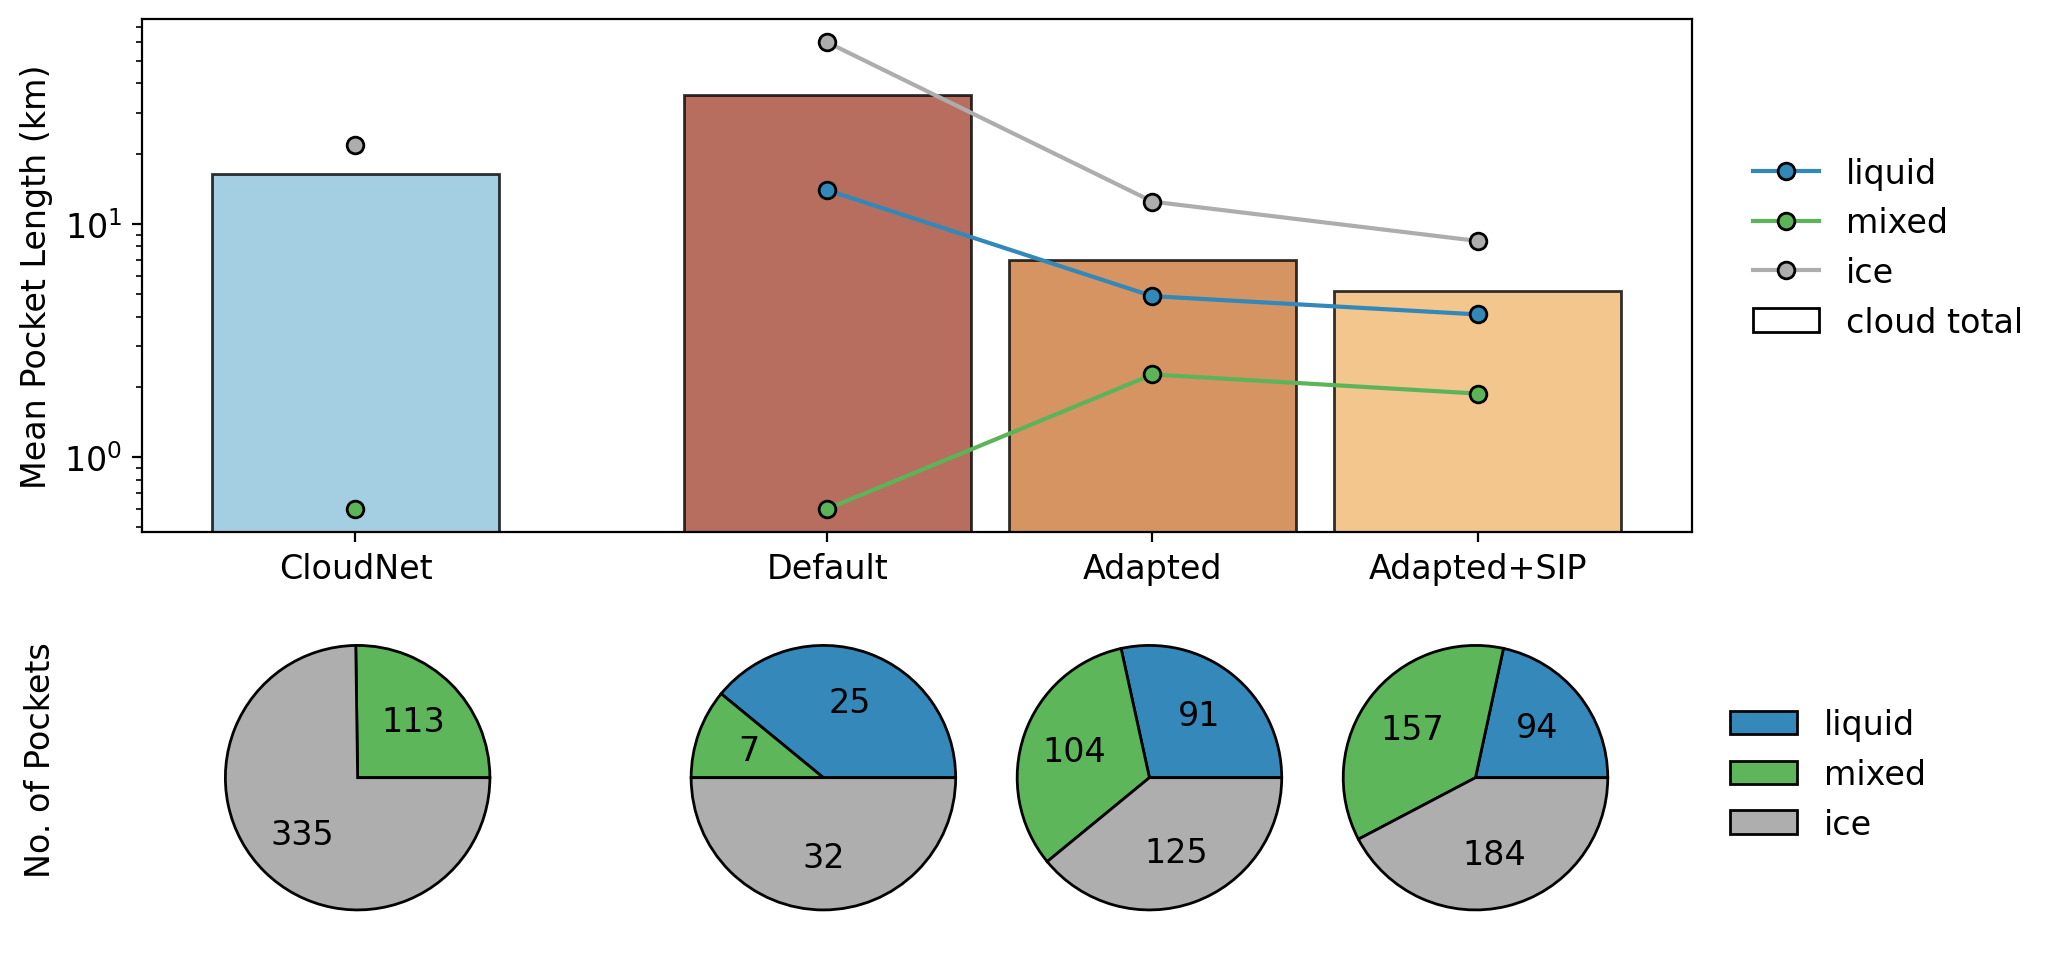

In [11]:
fig = plt.figure(figsize=(10, 6), tight_layout=True)
gs = gridspec.GridSpec(100, 100)

ax0 = fig.add_subplot(gs[0:55, :])

x_positions = [1, 2.48, 3.5, 4.52]


cloudtop_data = [get_segment_lengths(CN, n_layers=30, reference_level=None), 
       get_segment_lengths(MD3, n_layers=9, reference_level=None), 
       get_segment_lengths(MA3, n_layers=9, reference_level=None), 
       get_segment_lengths(MAS3, n_layers=9, reference_level=None)]


ax0.bar(x = x_positions, 
       height=[mean_length(d) * 0.6 for d in cloudtop_data], 
       width=0.9, 
       color=model_colors[1:], 
       edgecolor=['black']*3, linewidth=1, alpha=0.8, tick_label=['CloudNet', 'Default', 'Adapted', 'Adapted+SIP'])

ax0.bar(x=[2.17], height=0, alpha=1, label='cloud total', color='white', linewidth=1, edgecolor=['black']*2)



for phase in range(3):
    ax0.plot(x_positions[1:], [mean_length(d[phase]) * 0.6 for d in cloudtop_data[1:]], 
            color=phase_colors[phase], marker='o', label=phase_labels[phase], markeredgecolor='k')
    
    offset = False
    if offset:
        ax0.scatter(1 + (phase - 1) / 50, mean_length(cloudtop_data[0][phase]) * 0.6, color=phase_colors[phase], marker='o', edgecolors='k')
    else:
        ax0.scatter(1, mean_length(cloudtop_data[0][phase]) * 0.6, color=phase_colors[phase], marker='o', edgecolors='k')

ax0.legend(bbox_to_anchor=(1.02, 0.79), frameon=False)

dummy = fig.add_subplot(gs[80, 1])
dummy.spines['left'].set_visible(False)
dummy.spines['right'].set_visible(False)
dummy.spines['top'].set_visible(False)
dummy.spines['bottom'].set_visible(False)
dummy.set_xticks([])
dummy.set_yticks([])
dummy.set_ylabel('No. of Pockets', labelpad=36)



def make_autopct(values):
    # To show total counts instead of percantages
    def my_autopct(pct):
        total = sum(values)
        val = int(round(pct*total/100.0))
        if val == 0:
            return ''
        else:
            return '{v:d}'.format(v=val)
    return my_autopct


centers = [14, 44, 65, 86]

for i in range(4):
    x = fig.add_subplot(gs[65:, centers[i] - 12 : centers[i] + 12])
    counts = [sum(cloudtop_data[i][phase][1]) for phase in range(3)]
    x.pie(counts, colors=phase_colors, autopct=make_autopct(counts), wedgeprops={"alpha": 0.99, 'edgecolor':'k'})

x.legend(labels=phase_labels, bbox_to_anchor=(1.18, 0.8), frameon=False)

ax0.set_ylabel('Mean Pocket Length (km)')
ax0.set_yscale('log')
plt.tick_params(bottom=False)
fig.subplots_adjust(hspace=-0.55)

plt.show()

### Part 4: IWF Sensitivity

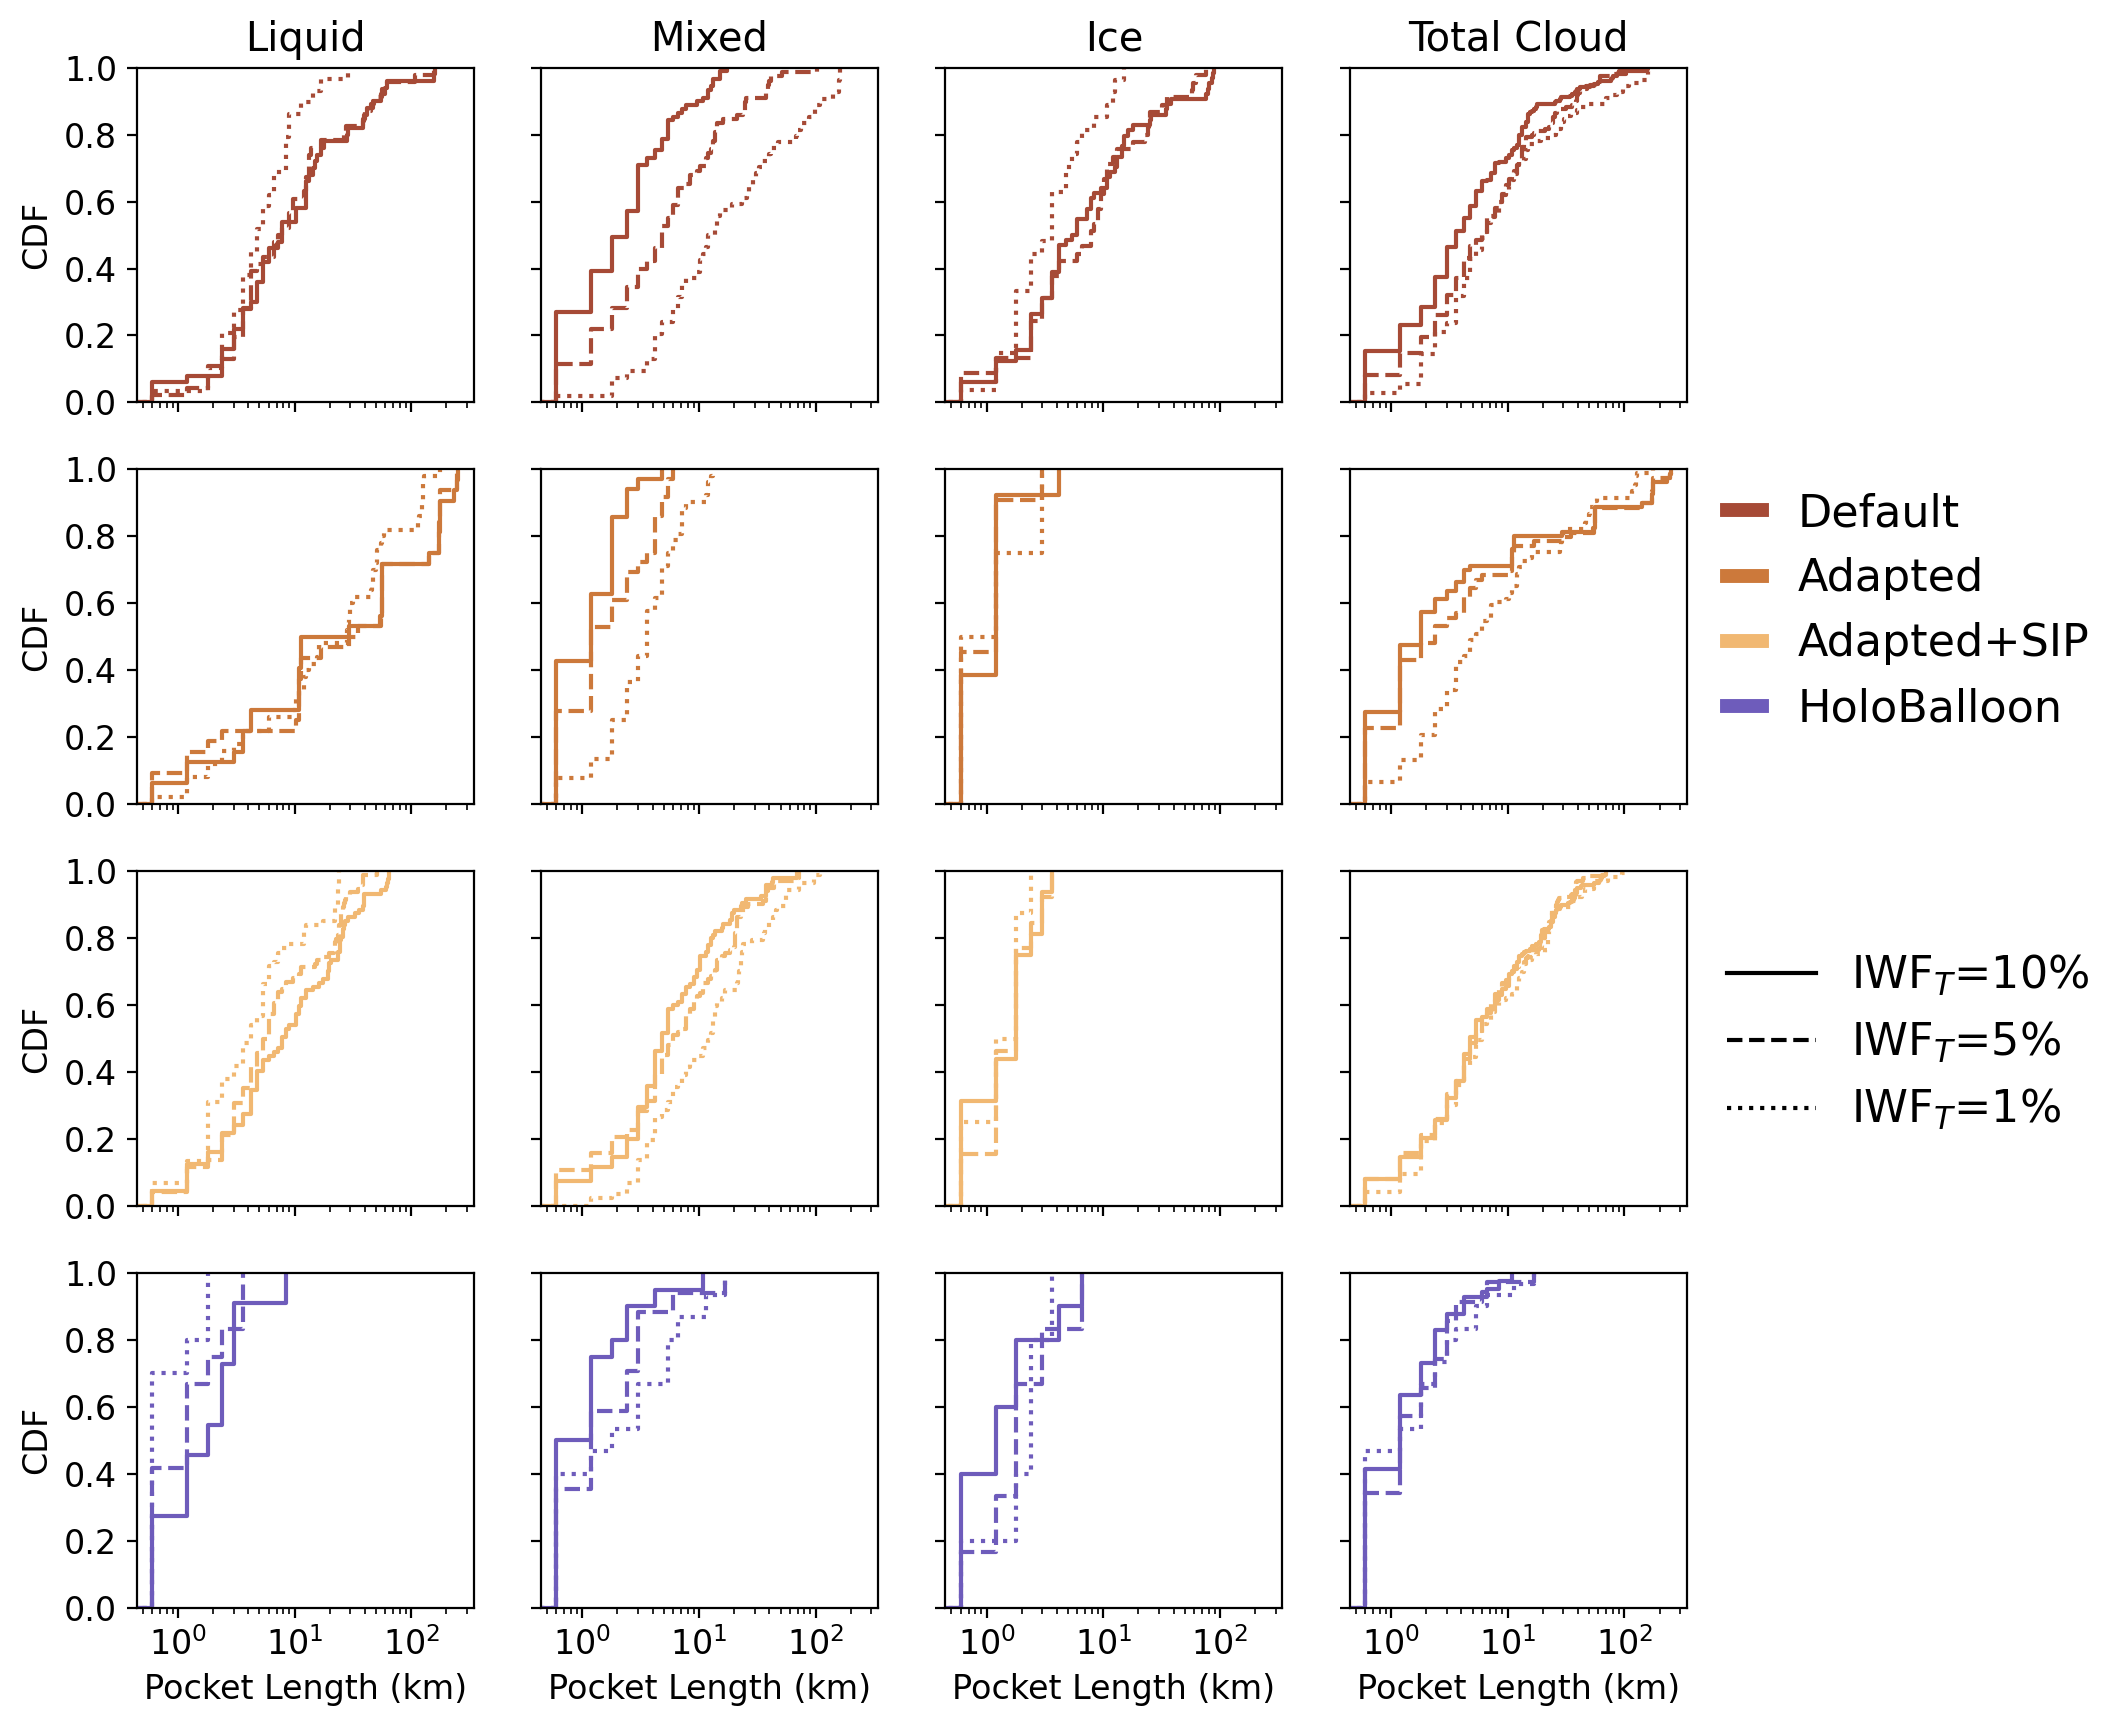

In [12]:
subsample = 2

# Making lists containing cloud classifications from each source given different choices of IWF thresholds
HB_list = []
MD3_list = []
MA3_list = []
MAS3_list = []
for T in [0.1, 0.05, 0.01]:
    HB_list.append(xr.concat([get_HB(path, tslice, threshold=T).isel(time=slice(None, None, subsample)) for path, tslice in zip((HB1_path, HB2_path, HB3_path), HB_tslices)], dim='time'))
    MD3_list.append(get_processed_data(MD3_processed_path, threshold=T).rename({'bottom_top': 'height', 'Time': 'time'}).isel(time=tslice_M))
    MA3_list.append(get_processed_data(MA3_processed_path, threshold=T).rename({'bottom_top': 'height', 'Time': 'time'}).isel(time=tslice_M))
    MAS3_list.append(get_processed_data(MAS3_processed_path, threshold=T).rename({'bottom_top': 'height', 'Time': 'time'}).isel(time=tslice_M))

# Producing pocket length statistics from each source and threshold
Ds = []
As = []
ASs = []
Hs = []
for i in range(3):
    Ds.append([L * 0.6 for L in repmat(continuous_indices(get_segment_lengths(MD3_list[i], n_layers=9, reference_level=32)))])
    As.append([L * 0.6 for L in repmat(continuous_indices(get_segment_lengths(MA3_list[i], n_layers=9, reference_level=32)))])
    ASs.append([L * 0.6 for L in repmat(continuous_indices(get_segment_lengths(MAS3_list[i], n_layers=9, reference_level=32)))])
    Hs.append([L * 0.3*subsample for L in repmat(get_segment_lengths(HB_list[i].isel(time=slice(None, None, 2)), n_layers=1))])


# Plotting
fig, ax = plt.subplots(4, 4, figsize=(10, 10), sharey=True, sharex=True)
stat = 'proportion'
sources = ['Default', 'Adapted', 'Adapted+SIP', 'HoloBalloon']
linestyles = ['solid', 'dashed', 'dotted']

for i, source in enumerate([Ds, As, ASs, Hs]):
    for T in range(3):
        for phase in range(3):
            sns.ecdfplot(source[T][phase], ax=ax[i, phase], linestyle=linestyles[T], color=colors[sources[i]])
        sns.ecdfplot(np.sort(np.concatenate(source[T])), linestyle=linestyles[T], color=colors[sources[i]], ax=ax[i, phase+1])
plt.xscale('log')

ax[3, 3].plot([-1, -2], [0, 1], linestyle=linestyles[0], color='k', label='IWF$_T$=10%')
ax[3, 3].plot([-1, -2], [0, 1], linestyle=linestyles[1], color='k', label='IWF$_T$=5%')
ax[3, 3].plot([-1, -2], [0, 1], linestyle=linestyles[2], color='k', label='IWF$_T$=1%')
ax[3, 3].legend(frameon=False, bbox_to_anchor=(1, 1.3), loc='lower left', fontsize=16)

for i in range(4):
    ax[2, 3].plot([-1, -2], [0, 1], color=colors[sources[i]], label=sources[i], linewidth=5)

ax[2, 3].legend(frameon=False, bbox_to_anchor=(1, 1.3), loc='lower left', fontsize=16, handlelength=0.8)

plt.xscale('log')
ax[0, 0].set_title('Liquid')
ax[0, 1].set_title('Mixed')
ax[0, 2].set_title('Ice')
ax[0, 3].set_title('Total Cloud')

[x.set_ylabel('CDF') for x in ax[:, 0]]
[x.set_xlabel('Pocket Length (km)') for x in ax[3, :]]

ax[0, 0].xaxis.set_label_coords(1, -0.16)
plt.show()


NameError: name 'CN_orig' is not defined

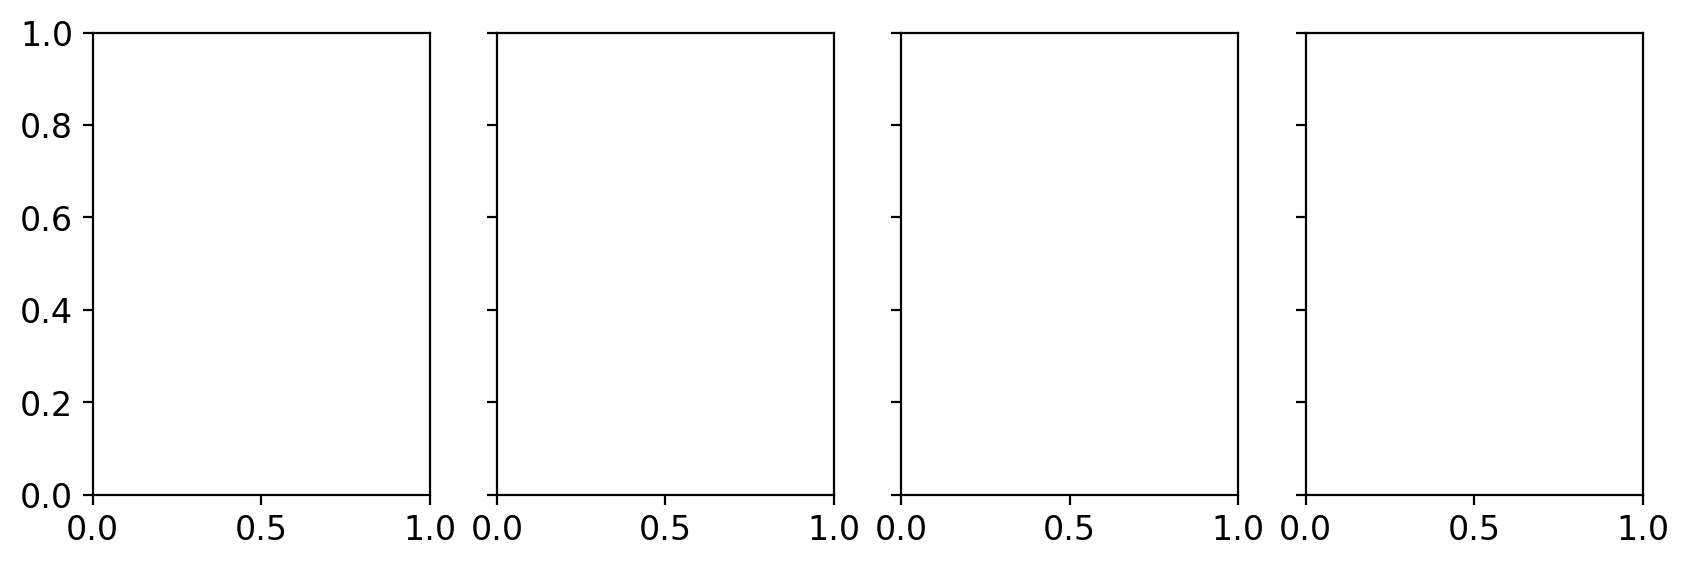

In [13]:
# Cloud interior

fig, ax = plt.subplots(1, 4, figsize=(10, 3), sharey=True, sharex=True)
colors = {'CloudNet 30s': '#8DC3DC', 'HoloBalloon 30s': '#6E5CBB', 'CloudNet 1min': '#8DC3DC', 'HoloBalloon 1min': '#6E5CBB'}


C = [L * 0.3 for L in repmat(continuous_indices(get_segment_lengths(CN_orig, n_layers=30, reference_level=137)))]
H = [L * 0.3 for L in repmat(get_segment_lengths(HB_orig, n_layers=1))]

liquid_df = pd.DataFrame([C[0], H[0]], index=['CloudNet 30s', 'HoloBalloon 30s']).T.assign(phase='liquid')
mixed_df = pd.DataFrame([C[1], H[1]], index=['CloudNet 30s', 'HoloBalloon 30s']).T.assign(phase='mixed')
ice_df = pd.DataFrame([C[2], H[2]], index=['CloudNet 30s', 'HoloBalloon 30s']).T.assign(phase='ice')
total_df = pd.DataFrame([np.concatenate([e[0], e[1], e[2]]) for e in [C, H]], index=['CloudNet 30s', 'HoloBalloon 30s']).T.assign(phase='total')

stat = 'proportion'

sns.ecdfplot(liquid_df, ax=ax[0], palette=colors, legend=False, stat=stat)
sns.ecdfplot(mixed_df, ax=ax[1], palette=colors, legend=False, stat=stat)
sns.ecdfplot(ice_df, ax=ax[2], palette=colors, legend=False, stat=stat)
sns.ecdfplot(total_df, ax=ax[3], palette=colors, legend=False, stat=stat)




# Reduced
C = [L * 0.6 for L in repmat(continuous_indices(get_segment_lengths(CN_red, n_layers=30, reference_level=137)))]
H = [L * 0.6 for L in repmat(get_segment_lengths(HB_red, n_layers=1))]

liquid_df = pd.DataFrame([C[0], H[0]], index=['CloudNet 1min', 'HoloBalloon 1min']).T.assign(phase='liquid')
mixed_df = pd.DataFrame([C[1], H[1]], index=['CloudNet 1min', 'HoloBalloon 1min']).T.assign(phase='mixed')
ice_df = pd.DataFrame([C[2], H[2]], index=['CloudNet 1min', 'HoloBalloon 1min']).T.assign(phase='ice')
total_df = pd.DataFrame([np.concatenate([e[0], e[1], e[2]]) for e in [C, H]], index=['CloudNet 1min', 'HoloBalloon 1min']).T.assign(phase='total')


sns.ecdfplot(liquid_df, ax=ax[0], palette=colors, legend=False, stat=stat, linestyle='dashed')
sns.ecdfplot(mixed_df, ax=ax[1], palette=colors, legend=False, stat=stat, linestyle='dashed')
sns.ecdfplot(ice_df, ax=ax[2], palette=colors, legend=False, stat=stat, linestyle='dashed')
sns.ecdfplot(total_df, ax=ax[3], palette=colors, legend=False, stat=stat, linestyle='dashed')

#sns.move_legend(ax[2], 'center right', bbox_to_anchor=(2, 0.6), frameon=False)
#sns.move_legend(ax[3], 'center right', bbox_to_anchor=(2, 0.4), frameon=False)

dummyax = ax[3].twinx()
dummyax.plot([100000, 100001], [100000, 100001], color='#8DC3DC', linestyle='solid', label='Cloudnet 30s')
dummyax.plot([100000, 100001], [100000, 100001], color='#8DC3DC', linestyle='dashed', label='Cloudnet 1min')
dummyax.plot([100000, 100001], [100000, 100001], color='#6E5CBB', linestyle='solid', label='HoloBalloon 30s')
dummyax.plot([100000, 100001], [100000, 100001], color='#6E5CBB', linestyle='dashed', label='HoloBalloon 1min')

dummyax.axis('off')
dummyax.legend(frameon=False, loc='center right', bbox_to_anchor=(2.4, 0.5))

plt.xscale('log')
#plt.ylim(0, 1.03)
ax[0].set_title('Liquid')
ax[1].set_title('Mixed')
ax[2].set_title('Ice')
ax[3].set_title('Total Cloud')
ax[3].set_xlim(0.2, 100)
ax[0].set_ylabel('CDF')
#[x.set_xlabel('pocket length (km)') for x in ax]
ax[1].set_xlabel('Pocket Length (km)')
ax[1].xaxis.set_label_coords(1, -0.16)
plt.subplots_adjust(wspace=0)
plt.show()